# Calibration

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from itertools import product as itproduct

In [3]:
from neuroprobnum.utils import math_utils
from neuroprobnum.utils import plot_utils as pltu

# Model

In [4]:
from neuroprobnum.models.hodgkin_huxley import compile_cython

compile_cython()

running build_ext



In [5]:
from neuroprobnum.models.hodgkin_huxley import HHNeuron

neuron = HHNeuron()
neuron

HH_neuron

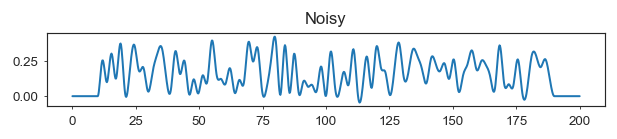

In [6]:
from neuroprobnum.utils import stim_utils

t0, tmax = 0, 200
stim_onset, stim_offset = 10, tmax-10
stim = stim_utils.IStimNoisy(Iamp=0.2, onset=stim_onset, offset=stim_offset, name='Noisy', nknots=101, seed=46)
stim.plot(t0=t0, tmax=tmax)

In [7]:
neuron.get_Istim_at_t = stim.get_I_at_t

# Data

## Generator

In [8]:
from neuroprobnum.generator.generator_hh import DataGeneratorHH, DataGeneratorHHus, DataGeneratorHHs

gen_types = {
    'us': (1e3, DataGeneratorHHus),
    'ms': (1, DataGeneratorHH),
    's': (1e-3, DataGeneratorHHs),
}

gens = dict()

for unit, (factor, gen_type) in gen_types.items():

    gen = gen_type(
        y0=neuron.compute_yinf(-65), t0=t0*factor, tmax=tmax*factor,
        t_eval_adaptive=math_utils.t_arange(t0*factor, tmax*factor, 1*factor),
        model=neuron, n_samples=100, n_parallel=20,
        gen_det_sols=True, gen_acc_sols=True, acc_same_ts=True,
        base_folder='data_compare_t_units',
    )
    gen.update_subfoldername(unit=unit)
    gen.load_acc_sols_from_file()    
    
    gens[unit] = (factor, gen)
    
gens

{'us': (1000.0,
  <neuroprobnum.generator.generator_hh.DataGeneratorHHus at 0x7fe542bc5d60>),
 'ms': (1,
  <neuroprobnum.generator.generator_hh.DataGeneratorHH at 0x7fe542bc5d90>),
 's': (0.001,
  <neuroprobnum.generator.generator_hh.DataGeneratorHHs at 0x7fe542bc4f10>)}

## Examples

us


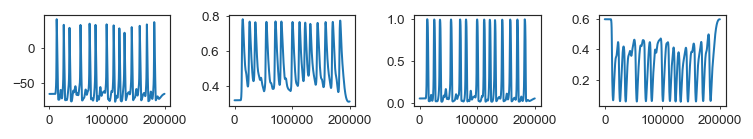

ms


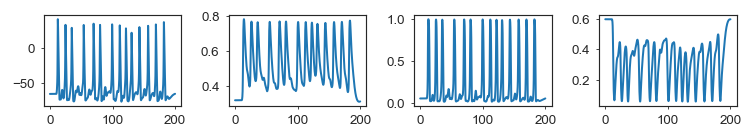

s


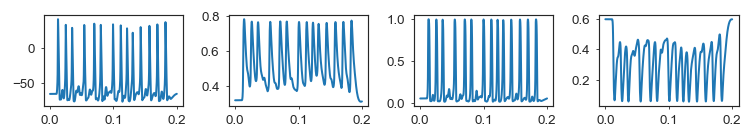

In [9]:
for unit, (factor, gen) in gens.items():
    print(unit)
    gen.gen_sol(method='EE', adaptive=False, step_param=0.1*factor, pert_method=None, n_samples=1).plot()

us


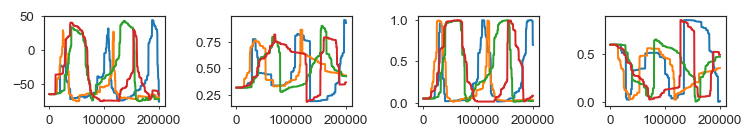

ms


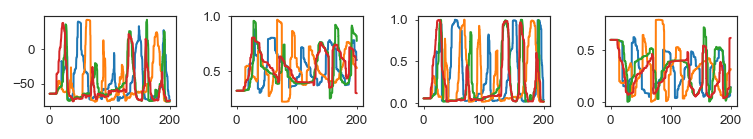

s


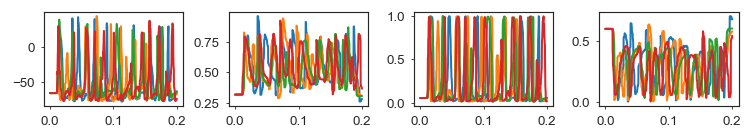

In [10]:
for unit, (factor, gen) in gens.items():
    print(unit)
    gen.gen_sol(method='EE', adaptive=False, step_param=0.1*factor, pert_param=1000, pert_method='abdulle_ln', n_samples=4).plot()

us


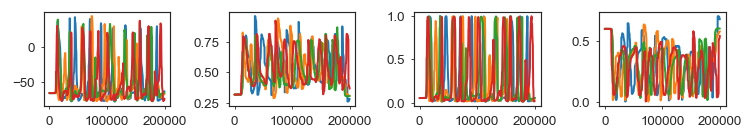

ms


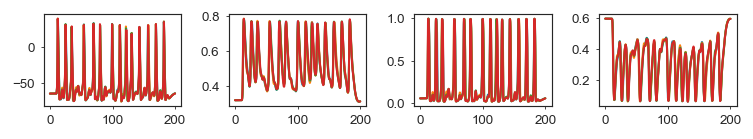

s


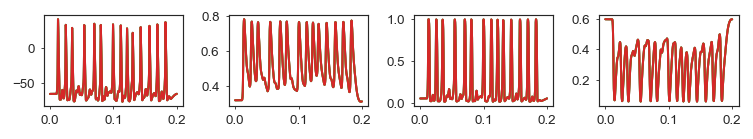

In [11]:
for unit, (factor, gen) in gens.items():
    print(unit)
    gen.gen_sol(method='EE', adaptive=False, step_param=0.1*factor, pert_param=1, pert_method='abdulle_ln', n_samples=4).plot()

us


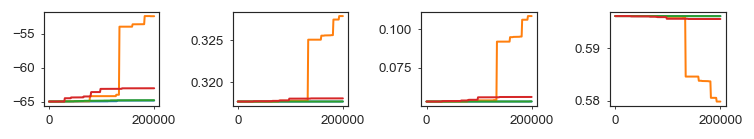

ms


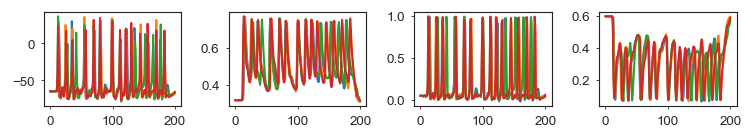

s


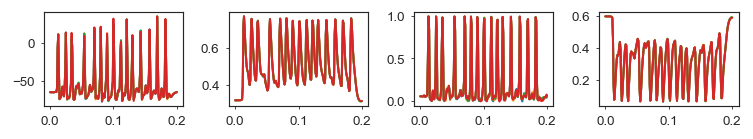

In [12]:
for unit, (factor, gen) in gens.items():
    print(unit)
    gen.gen_sol(method='RKBS', adaptive=True, step_param=1e-2, pert_method='abdulle_ln', n_samples=4).plot()

us


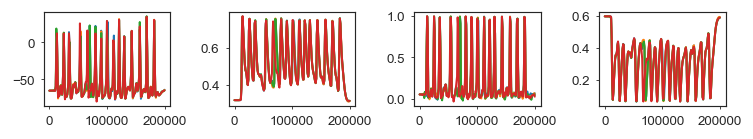

ms


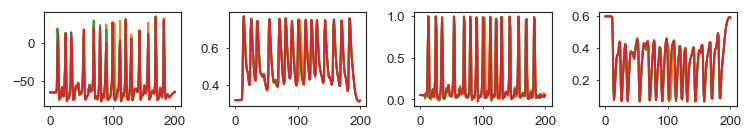

s


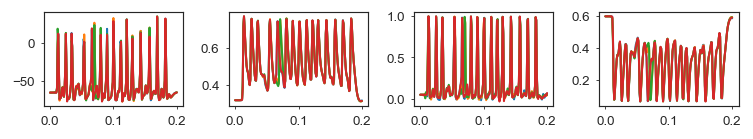

In [13]:
for unit, (factor, gen) in gens.items():
    print(unit)
    gen.gen_sol(method='RKBS', adaptive=True, step_param=1e-2, pert_method='conrad', n_samples=4).plot()

us


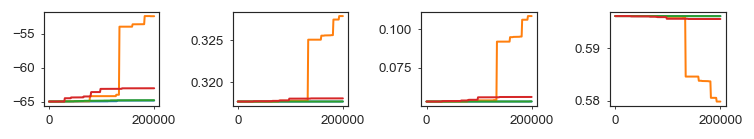

ms


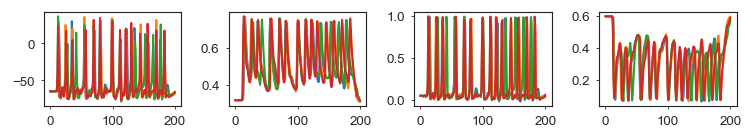

s


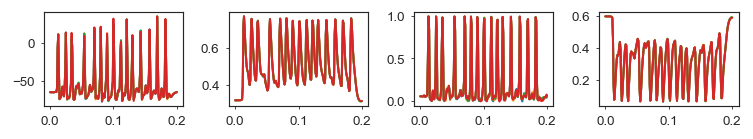

In [14]:
for unit, (factor, gen) in gens.items():
    print(unit)
    gen.gen_sol(method='RKBS', adaptive=True, step_param=1e-2, pert_method='abdulle_ln', n_samples=4).plot()

## Generate data

In [15]:
def get_pert_params(explb, expub, expstep):
    """Get pert params for given exponents"""
    pert_params = 2.** np.append(np.arange(explb, expub, float(expstep)), expub)
    return pert_params


# pert_method, adaptive, methods, step_params, pert_params
solver_params = [   
    ['abdulle_ln', 0, ['EE'], [0.025], get_pert_params(-16, 24, 1)],
    ['abdulle_ln', 0, ['EEMP'], [0.025], get_pert_params(-16, 24, 1)],
    #['abdulle_ln', 0, ['FE'], [0.025], get_pert_params(-16, 24, 1)],
 ]

In [16]:
np.random.seed(42)

seeds = np.random.randint(0, np.iinfo(np.int32).max, 10000)

i = 0
for unit, (factor, gen) in gens.items():

    print('----------------------------------------------------------')
    print(unit, ':', gen.subfoldername)
    print('----------------------------------------------------------') 
    
    for pert_method, adaptive, methods, step_params, pert_params in solver_params:
        for step_param, method, pert_param in itproduct(step_params, methods, pert_params):
            gen.gen_and_save_data(
                method=method, adaptive=adaptive, step_param=step_param*factor if not adaptive else step_param,
                pert_method=pert_method, pert_param=pert_param,
                overwrite=False, allowgenerror=False,
                seed=seeds[i],
            )
            i += 1

----------------------------------------------------------
us : unit_us_tmax_200000.0
----------------------------------------------------------
                     EE_f(0.025)_abdulle_ln(1.52588e-05).pkl --> Data already exists.
                     EE_f(0.025)_abdulle_ln(3.05176e-05).pkl --> Data already exists.
                     EE_f(0.025)_abdulle_ln(6.10352e-05).pkl --> Data already exists.
                      EE_f(0.025)_abdulle_ln(0.00012207).pkl --> Data already exists.
                     EE_f(0.025)_abdulle_ln(0.000244141).pkl --> Data already exists.
                     EE_f(0.025)_abdulle_ln(0.000488281).pkl --> Data already exists.
                     EE_f(0.025)_abdulle_ln(0.000976562).pkl --> Data already exists.
                      EE_f(0.025)_abdulle_ln(0.00195312).pkl --> Data already exists.
                      EE_f(0.025)_abdulle_ln(0.00390625).pkl --> Data already exists.
                       EE_f(0.025)_abdulle_ln(0.0078125).pkl --> Data already exi

## Load data

In [17]:
from neuroprobnum.generator.dataloader import DataLoader
from copy import deepcopy

df = pd.DataFrame()
for unit, (factor, gen) in gens.items():
    solver_params_unit = deepcopy(solver_params)
    
    for i, solver_params_i in enumerate(solver_params):        
        solver_params_unit[i][3] = [step_param*factor if not solver_params_i[1] else step_param for step_param in solver_params_i[3]]
        
    unit_df = DataLoader(gen).load_data2dataframe(solver_params_unit, drop_traces=False, allowgenerror=True)   
    unit_df['unit'] = unit
    unit_df.loc[unit_df.adaptive==0, 'step_param'] = unit_df.loc[unit_df.adaptive==0, 'step_param'] / factor
    df = df.append(unit_df, ignore_index=True)

In [18]:
import utils

utils.add_SR_SM(df)
df.head()

,MAE_DR,MAE_SM,MAE_SR,acc_ts,acc_vs,adaptive,det_nODEcalls,det_run_time,det_ts,det_vs,...,tmax,ts,vs,unit,MAE_SR_avg,MAE_SM_avg,MAER_SM_SR,MAER_DR_SR,MAERP_SM_DR,MAERP_SM_DR_c
0,4.367928,"[0.0006781107918888065, 0.00047783780402477254...","[4.367589037753794, 4.368047907211466, 4.36773...","[0.0, 25.0, 50.0, 75.0, 100.0, 125.0, 150.0, 1...","[-65.0, -64.99999197404844, -64.99998407512528...",0,8000.0,0.277474,"[0.0, 25.0, 50.0, 75.0, 100.0, 125.0, 150.0, 1...","[-65.0, -64.99999197539579, -64.99998408551515...",...,200000.0,"[0.0, 25.0, 50.0, 75.0, 100.0, 125.0, 150.0, 1...","[[-65.0, -64.99999197576447, -64.9999840858317...",us,4.367916,0.000490,0.000112,1.000003,0.000112,0.000112
1,4.367928,"[0.000773377934486352, 0.0005394120255040425, ...","[4.3674719219099245, 4.367895290572109, 4.3681...","[0.0, 25.0, 50.0, 75.0, 100.0, 125.0, 150.0, 1...","[-65.0, -64.99999197404844, -64.99998407512528...",0,8000.0,0.326027,"[0.0, 25.0, 50.0, 75.0, 100.0, 125.0, 150.0, 1...","[-65.0, -64.99999197539579, -64.99998408551515...",...,200000.0,"[0.0, 25.0, 50.0, 75.0, 100.0, 125.0, 150.0, 1...","[[-65.0, -64.99999197310657, -64.9999840817677...",us,4.367801,0.001002,0.000229,1.000029,0.000229,0.000229
2,4.367928,"[0.0023944429578522134, 0.0026784193316099995,...","[4.3696059185313425, 4.366549764353083, 4.3681...","[0.0, 25.0, 50.0, 75.0, 100.0, 125.0, 150.0, 1...","[-65.0, -64.99999197404844, -64.99998407512528...",0,8000.0,0.274843,"[0.0, 25.0, 50.0, 75.0, 100.0, 125.0, 150.0, 1...","[-65.0, -64.99999197539579, -64.99998408551515...",...,200000.0,"[0.0, 25.0, 50.0, 75.0, 100.0, 125.0, 150.0, 1...","[[-65.0, -64.99999197326449, -64.9999840835485...",us,4.368034,0.001880,0.000430,0.999976,0.000430,0.000430
3,4.367928,"[0.003544860256093495, 0.003000287218189067, 0...","[4.365287197849628, 4.369672985416371, 4.36855...","[0.0, 25.0, 50.0, 75.0, 100.0, 125.0, 150.0, 1...","[-65.0, -64.99999197404844, -64.99998407512528...",0,8000.0,0.291657,"[0.0, 25.0, 50.0, 75.0, 100.0, 125.0, 150.0, 1...","[-65.0, -64.99999197539579, -64.99998408551515...",...,200000.0,"[0.0, 25.0, 50.0, 75.0, 100.0, 125.0, 150.0, 1...","[[-65.0, -64.99999197898815, -64.9999840825746...",us,4.368004,0.004167,0.000954,0.999983,0.000954,0.000954
4,4.367928,"[0.008994993802694865, 0.006596277920970713, 0...","[4.361788403233761, 4.364380567962131, 4.37343...","[0.0, 25.0, 50.0, 75.0, 100.0, 125.0, 150.0, 1...","[-65.0, -64.99999197404844, -64.99998407512528...",0,8000.0,0.291258,"[0.0, 25.0, 50.0, 75.0, 100.0, 125.0, 150.0, 1...","[-65.0, -64.99999197539579, -64.99998408551515...",...,200000.0,"[0.0, 25.0, 50.0, 75.0, 100.0, 125.0, 150.0, 1...","[[-65.0, -64.99999200252952, -64.9999841163369...",us,4.367526,0.007936,0.001817,1.000092,0.001817,0.001817


# Plot

## Plot functions

In [19]:
def plot_R(ax, data_rows, x, plot_kw=dict(marker='.', ls = '-', c='k'), ylim=1.3, clipat=1.2, logfun=np.log2):
    """Plot MAE ratio for data rows."""

    ydata = data_rows[x]

    ylabel = pltu.metric2label(x)

    # Plot data
    ax.plot(logfun(data_rows.pert_param), np.minimum(ydata, clipat), clip_on=False, **plot_kw)
    
    # Highlight larger values
    if np.any(ydata > clipat):
        ax.plot(logfun(data_rows.pert_param)[ydata>clipat], np.minimum(ydata[ydata>clipat], clipat)[ydata>clipat],
                clip_on=True, color='darkred', marker='o', fillstyle='none', alpha=0.6, ls='none')

    ax.set_ylabel(pltu.text2mathtext(ylabel))
    if logfun == np.log10:
        ax.set_xlabel(pltu.text2mathtext("log_10 " + f"({pltu.pert_param_symbol})"))
    elif logfun == np.log2:
        ax.set_xlabel(pltu.text2mathtext("log_2 " + f"({pltu.pert_param_symbol})"))
    else:
        ax.set_xlabel(str(logfun))

    #ax.spines['left'].set_bounds([0, 1])
    ax.set(ylim=[-0.05, ylim], yticks=[0, 1])

In [20]:
def get_plot_kw(unit):
    plot_kw = dict(alpha=0.65, marker='.', markersize=3)
    if unit == 's':
        plot_kw['c'] = 'C0'
        plot_kw['label'] = unit
    elif unit == 'ms':
        plot_kw['c'] = 'C1'
        plot_kw['label'] = unit
    elif unit == 'us':
        plot_kw['c'] = 'C2'
        plot_kw['label'] = 'μs'
    return plot_kw

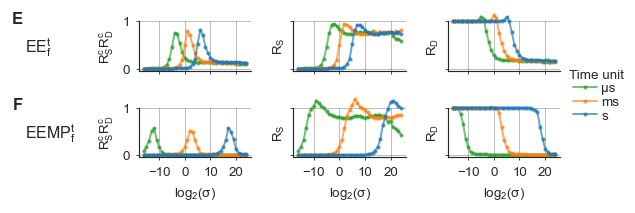

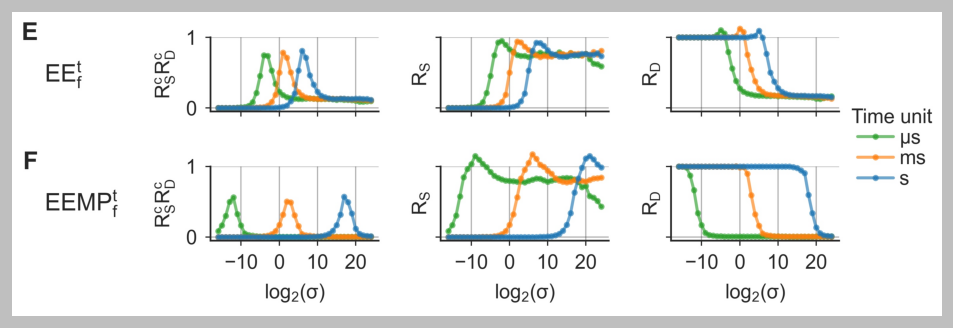

In [21]:
df_methods = df.groupby(by=['method', 'pert_method', 'adaptive', 'step_param'], sort=False)

n_rows = len(df_methods)
n_cols = 3

fig, axs = pltu.subplots(n_cols, n_rows, xsize='fullwidth', yoffsize=0.5, ysizerow=0.6, squeeze=False, sharex='all', sharey='all')
sns.despine()

for ax_row, ((method, pert_method, adaptive, step_param), df_method) in zip(axs , df_methods):
    pltu.row_title(ax_row[0], pltu.method2label(method=method, pert_method=pert_method, adaptive=adaptive), pad=40)
    for unit, data_rows in df_method.groupby(by=["unit"], sort=False):
        plot_R(ax=ax_row[0], data_rows=data_rows, x='MAERP_SM_DR_c', ylim=1.0, clipat=np.inf, plot_kw=get_plot_kw(unit))
        plot_R(ax=ax_row[1], data_rows=data_rows, x='MAER_SM_SR', ylim=1.0, clipat=np.inf, plot_kw=get_plot_kw(unit))
        plot_R(ax=ax_row[2], data_rows=data_rows, x='MAER_DR_SR', ylim=1.0, clipat=np.inf, plot_kw=get_plot_kw(unit))
        
pltu.make_share_ylims(axs)
pltu.grid(ax=axs)

pltu.set_labs(axs[:, 0], panel_nums=['E', 'F'], panel_num_space=25, panel_num_va='center', panel_num_y=1.05)

plt.tight_layout(pad=0.5, h_pad=0.0, w_pad=1.5, rect=[0.02, 0, 0.9, 1])

for ax in axs[0, :]:
    ax.set_xlabel(None)
    
for ax in axs.flat:
    ax.set_xticks([-10, -0, 10, 20])

axs[0, -1].legend(loc='center left', bbox_to_anchor=(1.05, -0.5), title='Time unit')

pltu.savefig("fig6e_f")

plt.show()
pltu.show_saved_figure(fig)

# Text

In [22]:
df_methods = df.groupby(by=['method', 'pert_method', 'adaptive', 'step_param'], sort=False)

best_pert_param = dict()
for (method, pert_method, adaptive, step_param), df_method in df_methods:
    print(method, pert_method, adaptive, step_param)
    best_pert_param[(step_param, method)] = dict()
    for unit, data_rows in df_method.groupby(by=["unit"], sort=False):
        best_row = data_rows.iloc[data_rows.MAERP_SM_DR_c.argmax()]
        print(best_row.unit, best_row.pert_param, best_row.step_param)
        
        best_pert_param[(step_param, method)][best_row.unit] = best_row.pert_param
    print()

EE abdulle_ln 0 0.025
us 0.0625 0.025
ms 2.0 0.025
s 64.0 0.025

EEMP abdulle_ln 0 0.025
us 0.000244140625 0.025
ms 4.0 0.025
s 131072.0 0.025



In [23]:
best_pert_param

{(0.025, 'EE'): {'us': 0.0625, 'ms': 2.0, 's': 64.0},
 (0.025, 'EEMP'): {'us': 0.000244140625, 'ms': 4.0, 's': 131072.0}}

In [24]:
method = 'EEMP'
unit = 'us'
h_ms = 0.025

if unit == 'ms':
    factor = 1
elif unit == 's':
    factor = 1e-3
elif unit == 'us':
    factor = 1e3

pert_param = best_pert_param[(h_ms, method)][unit]

In [25]:
solver = gens['us'][1].get_solver(method=method, adaptive=False, step_param=h_ms*factor, pert_method='abdulle_ln', pert_param=pert_param)

In [26]:
h = solver.h0
h

25.0

In [27]:
print(f"{solver.pert_param:.2g}")

0.00024


In [28]:
msquared = h ** 2
logn_var = solver.pert_param**2 * h**(2 * solver.pert_param_order + 1)
phi = np.sqrt(logn_var + msquared)
solver._pert_mu = np.log(msquared / phi)
solver._pert_sigma = np.sqrt(np.log(phi ** 2 / msquared))

In [29]:
print(logn_var)
print(h)
print(f"{np.sqrt(logn_var) / h:%}")

0.5820766091346741
25.0
3.051758%
